# Emotion recognition using EEG and computer games (+micro:bit)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os

# Constants
SAMPLE_RATE = 32 # (Hz)
GAMES = ["boring", "calm", "horror", "funny"]

## Preprocess the data

1. Read and plot the data.

In [71]:
# Read the data
data = []
for game_id, game in enumerate(GAMES):
    game_data = pd.read_csv(os.path.join("data", f"S01G{game_id + 1}AllChannels.csv"))
    game_data["game"] = game
    data.append(game_data)

data = pd.concat(data, axis = 0, ignore_index = True)

data.head()

,AF3,AF4,F3,F4,F7,F8,FC5,FC6,O1,O2,P7,P8,T7,T8,Unnamed: 14,game
0,-33.0205,-15.1846,-42.1795,1.6872,42.1793,-1.68720,-5.5436,-3.6154,25.7899,-9.88190,5.5436,7.47180,11.8101,17.1128,NaN,boring
1,-28.6291,-20.0583,-42.5410,-10.4653,35.3100,-15.68600,-19.3110,-2.4344,17.4933,3.24420,18.7081,5.09510,17.3683,3.0708,NaN,boring
2,-21.8497,-10.9006,-32.0346,-2.3656,39.6993,-0.64483,-4.0523,-1.0830,26.8081,-3.45840,8.1861,8.40480,15.1209,9.3940,NaN,boring
3,-25.1185,-10.9702,-32.7641,-3.4287,32.7378,4.69650,-8.6299,-1.7412,16.7637,-9.75860,1.1868,0.91086,4.3315,8.1073,NaN,boring
4,-19.0316,-9.5886,-29.1108,-3.9459,35.3533,0.79929,-12.6914,1.0144,13.1068,-0.73692,8.1054,-1.31300,8.1694,8.3442,NaN,boring


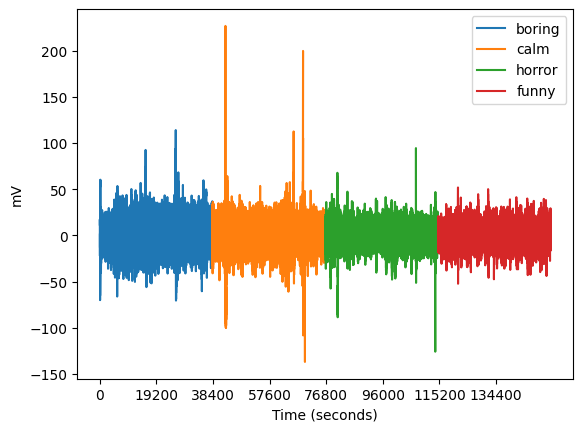

In [ ]:
# TODO: choose one of the frontal (F3 / F4 / F7 / F8 / FC5 / FC6) or temporal (T7 / T8) electrodes and ensure the signal is clean
electrode = "T7"

fig, ax = plt.subplots(1, 1)
for game in GAMES:
    ax.plot(data[data["game"] == game][electrode], label = game)
ax.set_xlabel("Time (seconds)")
ax.set_xticks(range(0, len(data), SAMPLE_RATE * 60 * 10))
ax.set_ylabel("mV")

ax.legend()

2. Use the chosen electrode and create a dataset of X-second clips.

In [73]:
# TODO: re-reference the data if needed
# ...

In [74]:
data = data[[electrode, "game"]]
data.head()

,T7,game
0,11.8101,boring
1,17.3683,boring
2,15.1209,boring
3,4.3315,boring
4,8.1694,boring


In [75]:
# TODO: adjust if needed
clip_length = 2 # (seconds)

# Split into clips
clipped_data = []
y = []
for game_id, game in enumerate(GAMES):
    clips = np.array_split(
        data[data['game'] == game][electrode].to_numpy(), 
        len(data[data['game'] == game]) // (clip_length * SAMPLE_RATE))
    clipped_data.extend(clips)
    y.extend([game_id] * len(clips))

# Remove edge effects
min_length = np.min([len(arr) for arr in clipped_data])
X = []
for array in clipped_data:
    X.append(array[:min_length])

X = np.vstack(X, dtype = float)
y = np.array(y, dtype = int)

print(X.shape)
print(y.shape)

(2388, 64)
(2388,)


## Train a CNN model

In [76]:
np.random.seed(123)

# Add an additional axis required by torch's Conv layers
X = np.expand_dims(X, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Convert to torch tensors
X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

print(X_train.shape)

torch.Size([1671, 1, 64])


In [77]:
class LFPDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        self.X = X
        self.y = y.long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [78]:
# Batch generators

# TODO: adjust if needed
batch_size = 32

train_batch_generator = torch.utils.data.DataLoader(LFPDataset(X_train, y_train), batch_size = batch_size,
                                                    shuffle = True)

test_batch_generator = torch.utils.data.DataLoader(LFPDataset(X_test, y_test), batch_size = batch_size,
                                                    shuffle = False)

In [79]:
# TODO: adjust if needed
model = torch.nn.Sequential(
    torch.nn.Conv1d(1, 1, kernel_size = 4, padding = "same"),
    torch.nn.ReLU(),
    torch.nn.Conv1d(1, 1, kernel_size = 4, padding = "same"),
    torch.nn.Flatten(),
    torch.nn.Linear(64, 4),
    torch.nn.LogSoftmax(dim = 1)
)

In [80]:
def train(n_epoch, model):
    # TODO: adjust learning rate if needed
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

    for e in range(n_epoch):
        model.train(True)

        train_loss = []
        train_acc = []
        for X_batch, y_batch in train_batch_generator:
            model.zero_grad()
            logits = model(X_batch).squeeze()
            loss = torch.nn.functional.nll_loss(logits, y_batch)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.detach().numpy())
            
            prediction = torch.softmax(logits, dim = 1).detach().numpy()
            prediction = np.argmax(prediction, axis = 1)
            train_acc.append(accuracy_score(y_batch.detach().numpy(), prediction))

        model.train(False)
        test_loss = []
        test_acc = []
        with torch.no_grad():
            for X_batch, y_batch in test_batch_generator:
                logits = model(X_batch).squeeze()
                loss = torch.nn.functional.nll_loss(logits, y_batch)
                test_loss.append(loss.detach().numpy())

                prediction = torch.softmax(logits, dim = 1).detach().numpy()
                prediction = np.argmax(prediction, axis = 1)
                test_acc.append(accuracy_score(y_batch.detach().numpy(), prediction))

        print(f"Epoch {e} : train_loss={np.mean(train_loss)}, train_acc={np.mean(train_acc)}, test_loss={np.mean(test_loss)}, test_acc={np.mean(test_acc)}")

    return model

In [ ]:
train(n_epoch = 100, model = model)

Epoch 0 : train_loss=1.7378970384597778, train_acc=0.2518530997304582, test_loss=1.668131947517395, test_acc=0.24372909698996656
Epoch 1 : train_loss=1.6911776065826416, train_acc=0.24410377358490565, test_loss=1.6358897686004639, test_acc=0.25188127090301005
Epoch 2 : train_loss=1.6482576131820679, train_acc=0.24267183288409702, test_loss=1.6090413331985474, test_acc=0.26066053511705684
Epoch 3 : train_loss=1.6167405843734741, train_acc=0.24090296495956873, test_loss=1.5860633850097656, test_acc=0.26066053511705684
Epoch 4 : train_loss=1.5933032035827637, train_acc=0.24123989218328842, test_loss=1.5664855241775513, test_acc=0.2633779264214047
Epoch 5 : train_loss=1.5615816116333008, train_acc=0.2424191374663073, test_loss=1.5495407581329346, test_acc=0.2660953177257525
Epoch 6 : train_loss=1.5436371564865112, train_acc=0.24393530997304583, test_loss=1.535090684890747, test_acc=0.26473662207357856
Epoch 7 : train_loss=1.53550124168396, train_acc=0.24528301886792453, test_loss=1.5223798

Sequential(
  (0): Conv1d(1, 1, kernel_size=(4,), stride=(1,), padding=same)
  (1): ReLU()
  (2): Conv1d(1, 1, kernel_size=(4,), stride=(1,), padding=same)
  (3): Flatten(start_dim=1, end_dim=-1)
  (4): Linear(in_features=64, out_features=4, bias=True)
  (5): LogSoftmax(dim=1)
)

## Make a prediction and project to the micro:bit

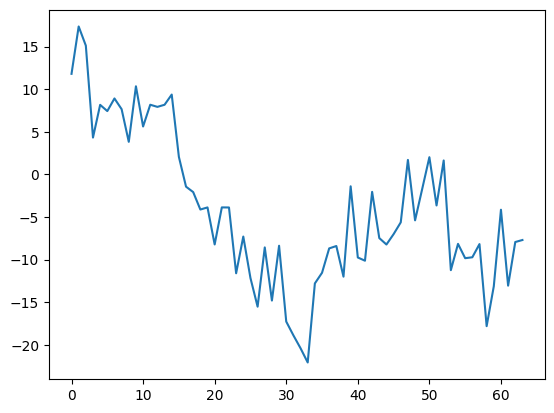

In [87]:
a_clip = X[0]
plt.plot(a_clip.flatten())

In [103]:
prediction = model(torch.tensor(np.expand_dims(a_clip, 1)).float())
prediction = torch.softmax(prediction, dim = 1).detach().numpy()
prediction = int(np.argmax(prediction, axis = 1)[0])

GAMES[prediction]

'calm'

In [ ]:
# TODO: your code for projecting to the micro:bit
# ...